# Lyrics Analysis

This notebook is aimed at analyzing the features that are presented in the dataset concerning lyrics.

## Loading the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

from pyspark import SparkContext

In [2]:
mxm_data = sc.pickleFile("../data/mxm_dataset_all/")
mbz_data = sc.pickleFile("../data/mbz_year/").map(lambda x: (x[0], {'year': x[1]}))

In [3]:
def flattenDicts(ls):
    """This methods merges dictionaries that are present in a list.
    If the same key is present multiple times, the value of the last 
    dictionary to have this key will be kept."""
    if len(ls) > 1:
        acc = ls[0].copy()
        for x in ls[1:]:
            acc.update(x)
        return acc
    else:
        return ls[0]

## Merging the data

In [4]:
rdd = mbz_data.join(mxm_data).map(lambda x: (x[0], flattenDicts(x[1])))
print("The RDD contains %d elements" % rdd.count())

The RDD contains 237662 elements


## Counting totals

We currently have an RDD where each song has its amount of occurences of the 5000 globally most common words.

In [5]:
def aggWordCount(localRes, newElem):
    if len(localRes) == 0:
        res = {}
        for (k, v) in newElem[1]:
            res[k] = v
        return res
    else:
        for (k, v) in newElem[1]:
            if k in localRes:
                localRes[k] += v
            else:
                localRes[k] = v
        return localRes
    
def combResults(a, b):
    if len(a) == 0:
        return b
    else:
        res = {}
        for k in a:
            res[k] = a[k]
        for k in b:
            if k in res:
                res[k] += b[k]
            else:
                res[k] = b[k]
        return res

In [6]:
cnts = rdd.map(lambda x: (x[0], x[1]["words"])).aggregate({}, aggWordCount, combResults)

## Filtering stop words

Some words are uninteresting to keep, for example pronouns are expected to be more common than verbs because of grammatical construction. Therefore we will filter them out to try and keep only words of interest. 

Some words like `la` or `que` could be candidates for filtering. `la` could be seen as the French determinant, but it could also be seen as the onomatopoeia for singing. Therefore we keep it. `que` is the same story, but it is interesting to keep because it can represent the spanish word `qué` and therefore we could see spanish presence in the songs.

In [7]:
# This list is taken from the sklearn stop_words package
# https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py
# which in turn is taken from the Glasgow Information Retrieval Group 
# http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words
ENGLISH_STOP_WORDS = [
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
"yourselves"]

stemmed_stop_words = ['onli', 'whi']

In [8]:
def filter_occ_totals(occurences):
    acc = {}

    for k in occurences:
        if k not in stemmed_stop_words and k not in ENGLISH_STOP_WORDS:
            acc[k] = occurences[k]
    
    return acc

In [9]:
filtered_cnts = filter_occ_totals(cnts)

## Determine globally most prominent words

In [10]:
# Dictionaries keys are not sorted, therefore we get a list of sorted keys
# by using this *trick* (we reverse it to see the best first)
most_prominent_keys = sorted(filtered_cnts, key=filtered_cnts.get, reverse=True)
    
for k in most_prominent_keys[:20]:
    print("%s : %s" % (k, filtered_cnts[k]))

love : 298043
know : 273137
like : 227624
just : 226250
time : 181248
come : 180061
oh : 178751
got : 170641
la : 156568
que : 154345
want : 140144
let : 138391
feel : 135366
make : 135332
say : 131303
ca : 126690
way : 125963
babi : 124647
yeah : 120885
day : 105957


Let's plot the distribution of the occurences by word, sorted by the occurence:

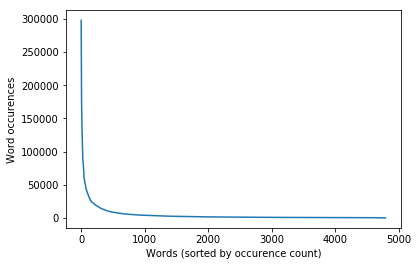

In [11]:
plt.plot(range(0, len(filtered_cnts)), [filtered_cnts[k] for k in most_prominent_keys])
plt.xlabel("Words (sorted by occurence count)")
plt.ylabel("Word occurences")
plt.show()

As expected, we are faced with a [Pareto distribution](https://en.wikipedia.org/wiki/Zipf%27s_law).

## Analyze the occurences weighted by hotness

In this part, we will try to see if weighting the occurences by the hotness of the song yields different results, that is to see if songs that are popular benefit from the usage of certain words.

In [12]:
def weigh_occ_by_hotness(x):
    ls = []
    hn = np.exp(1 + x[1]['hotness'])
    if np.isnan(hn):
        hn = 1
    for k in x[1]['words']:
        ls.append((k[0], k[1] * hn))
    x[1]['words'] = ls
    return x

metadata_rdd = sc.pickleFile("../data/metadata-songs/").map(lambda x: (x[0], {'hotness': x[1]['song_hotttnesss'][0]}))
metadata_rdd.filter(lambda x: x[1]['hotness'] > 0)

hot_rdd = rdd.join(metadata_rdd).map(lambda x: (x[0], flattenDicts(x[1])))

weighted_rdd = hot_rdd.filter(lambda x: not np.isnan(x[1]['hotness'])).map(weigh_occ_by_hotness)

weighted_cnts = weighted_rdd.map(lambda x: (x[0], x[1]["words"])).aggregate({}, aggWordCount, combResults)

weighted_filtered_cnts = filter_occ_totals(weighted_cnts)

In [13]:
most_prominent_weighted_keys = sorted(weighted_filtered_cnts, key=weighted_filtered_cnts.get, reverse=True)

for word in most_prominent_weighted_keys[:20]:
    print("%s : %d" % (word, weighted_filtered_cnts[word]))

love : 10073
know : 9716
like : 8801
just : 7916
come : 7582
got : 6241
oh : 6050
time : 5783
say : 5264
want : 5114
let : 5068
que : 4962
babi : 4920
make : 4627
feel : 4478
yeah : 4385
ca : 4088
way : 4087
day : 4019
caus : 3718


We can see that the distribution is about the same for the words even though we weigh by popularity. This indicates that song popularity is not determined by word usage in most cases.

## WordCloud

We will now try to visualize the word occurences by generating a word cloud where the size of the word is determined by its importance.

### Standard data

In [14]:
def make_wordcloud(occurences, fname=None, mask=None):
    try:
        import wordcloud

        wc = wordcloud.WordCloud(width=2000, height=1500, max_words=1000, mask=mask, random_state = 2)
        wc.generate_from_frequencies(occurences)
        
        if fname is not None:
            plt.imsave(fname, wc)

        plt.figure(figsize=[15,15])
        plt.imshow(wc)
        plt.axis('off')
        plt.show()
    except ImportError:
        print("wordcloud package not installed, use `pip install wordcloud`")

In [15]:
note_mask = plt.imread('../images/note.png', format='I')

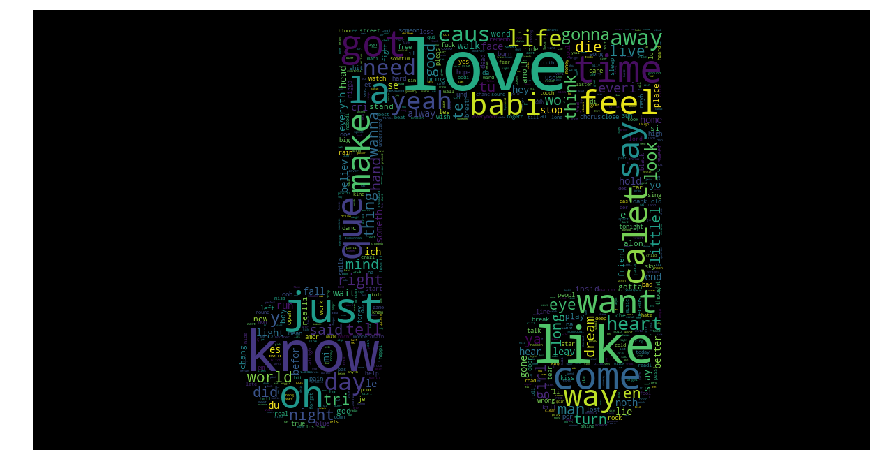

In [16]:
make_wordcloud(filtered_cnts, mask=note_mask)

### Hotness weighted data

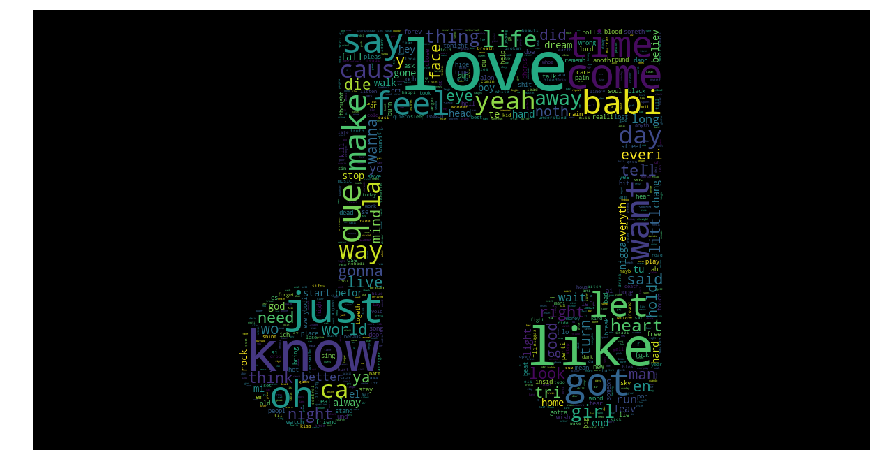

In [17]:
make_wordcloud(weighted_filtered_cnts, mask=note_mask)

## Evolution over time

In this section, we will try to visualize the evolution of the ranks of the words over time. This may show usage of different words over time. When visualizing this, we need to be careful: the million song dataset may be huge, but it does not contain every song every made. Therefore the representation may be skewed towards english words.

In [18]:
step = 5 #years
yearWordsOcc = {}

for year in range(1950, 2011, step):
    year_rdd = rdd.filter(lambda x: x[1]["year"] >= year and x[1]["year"] < year+step)
    year_cnts = year_rdd.map(lambda x: (x[0], x[1]["words"])).aggregate({}, aggWordCount, combResults)
    filtered_year_cnts = filter_occ_totals(year_cnts)
    yearWordsOcc[year] = filtered_year_cnts

In [19]:
orderedYearKeys = sorted(yearWordsOcc.keys())

In [20]:
# Calculate rank for each word for each year
yearWordsRank = {}

for year in yearWordsOcc:
    orderedKeys = sorted(yearWordsOcc[year], key=yearWordsOcc[year].get, reverse=True)
    i = 1
    yearRanks = {}
    for key in orderedKeys:
        yearRanks[key] = i
        i += 1
    yearWordsRank[year] = yearRanks
    
# Fill in empty years for each word
for word in yearWordsRank:
    for year in orderedYearKeys:
        if year not in yearWordsRank[word].keys():
            yearWordsRank[word][year] = None

In [21]:
wordsYearRank = {}

for year in orderedYearKeys:
    for word in yearWordsRank[year]:
        if word in wordsYearRank.keys():
            wordsYearRank[word][year] = yearWordsRank[year][word]
        else:
            wordsYearRank[word] = {year: yearWordsRank[year][word]}

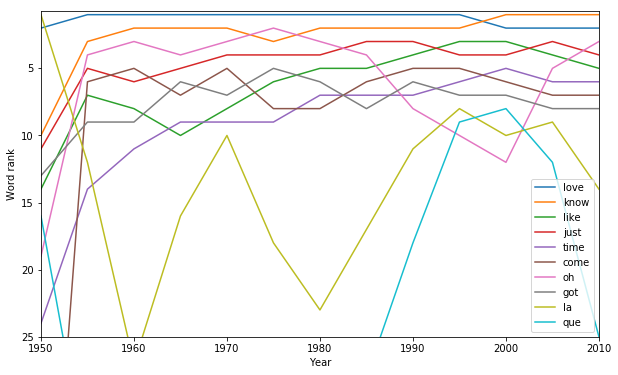

In [22]:
plt.figure(figsize=[10,6])

for word in most_prominent_keys[:10]:
    plt.plot(orderedYearKeys, [wordsYearRank[word][year] for year in orderedYearKeys])
    
plt.legend(most_prominent_keys[:10])
ax = plt.gca()
ax.set_autoscale_on(False)
plt.axis([1950, 2010, 25, 0.7])
plt.xlabel("Year")
plt.ylabel("Word rank")
#plt.savefig("word_rank_5y.png", bbox_inches='tight') # decomment if you want to save the graph
plt.show()

Year 1950


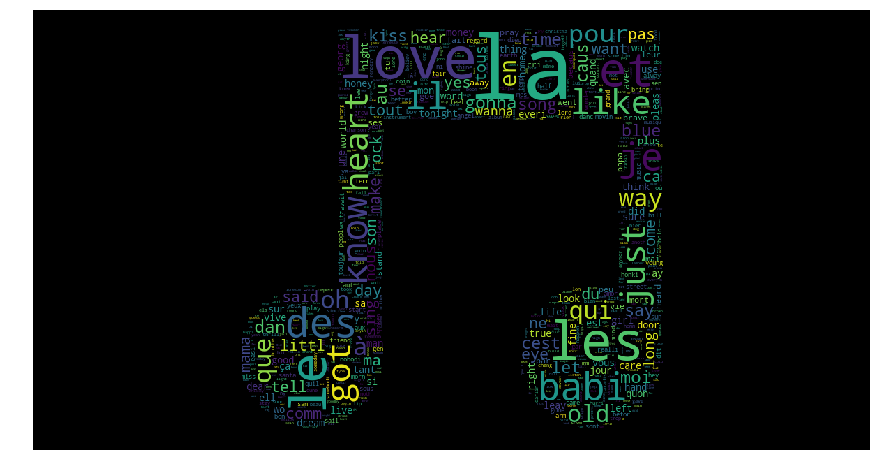

Year 1955


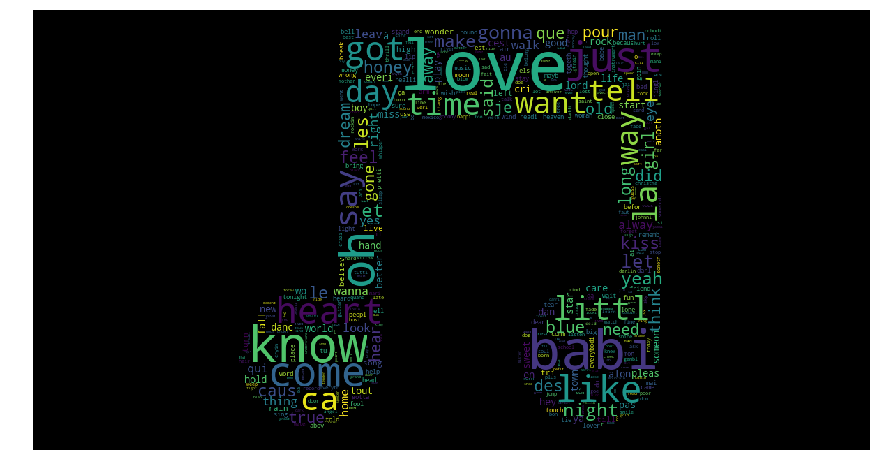

Year 1960


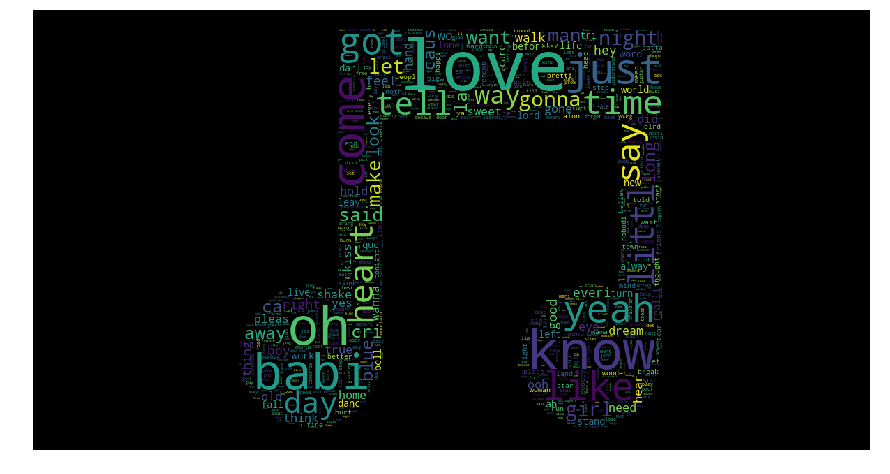

Year 1965


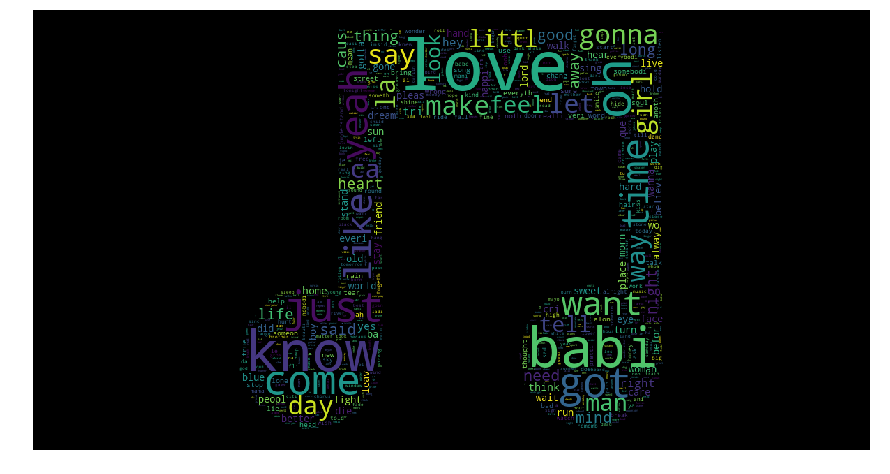

Year 1970


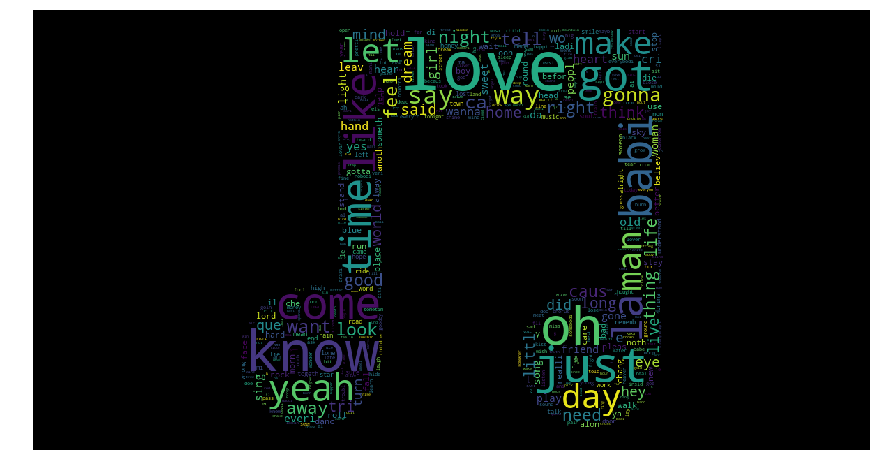

Year 1975


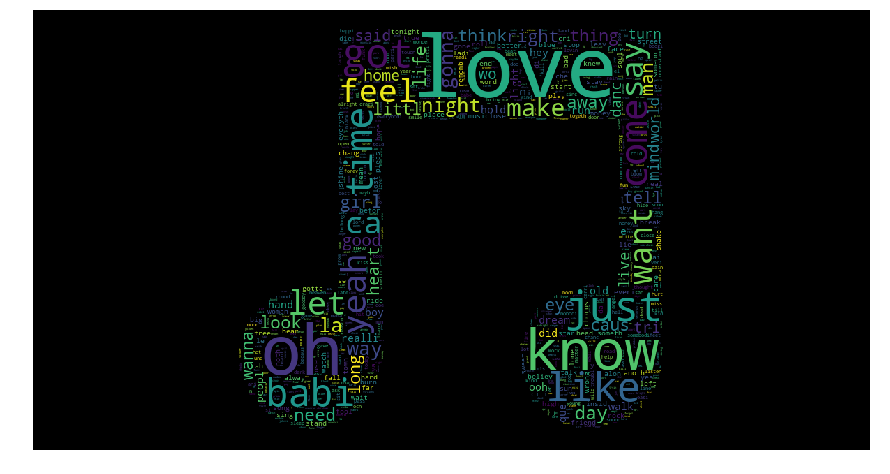

Year 1980


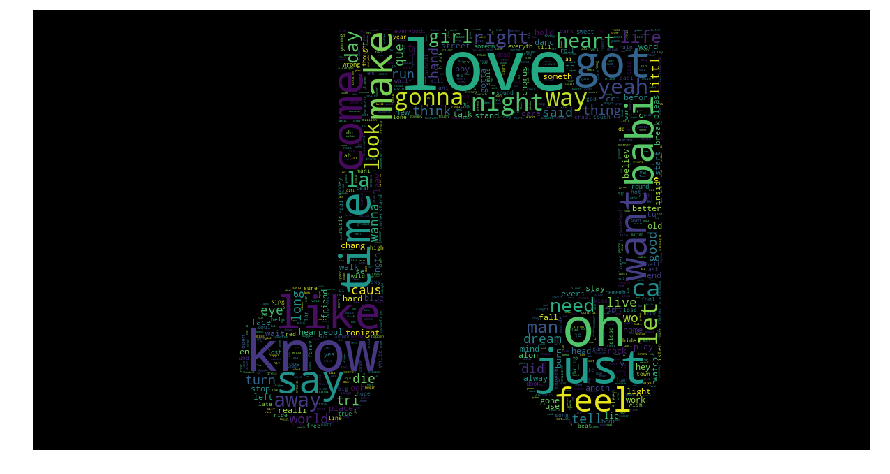

Year 1985


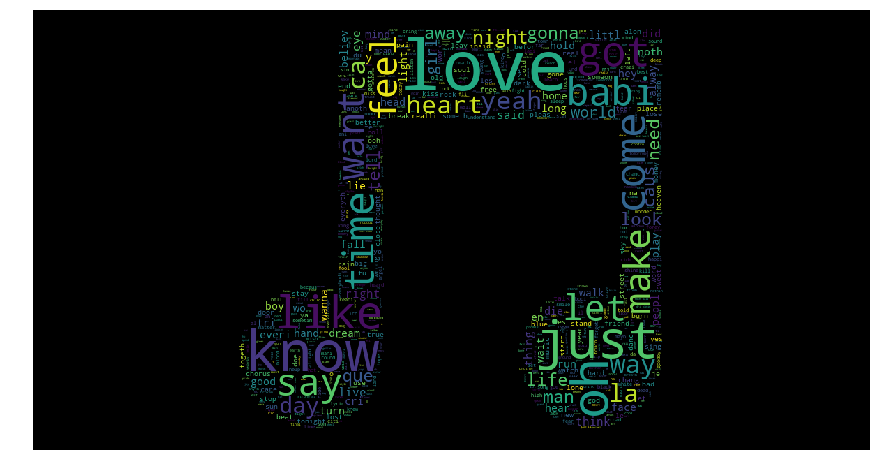

Year 1990


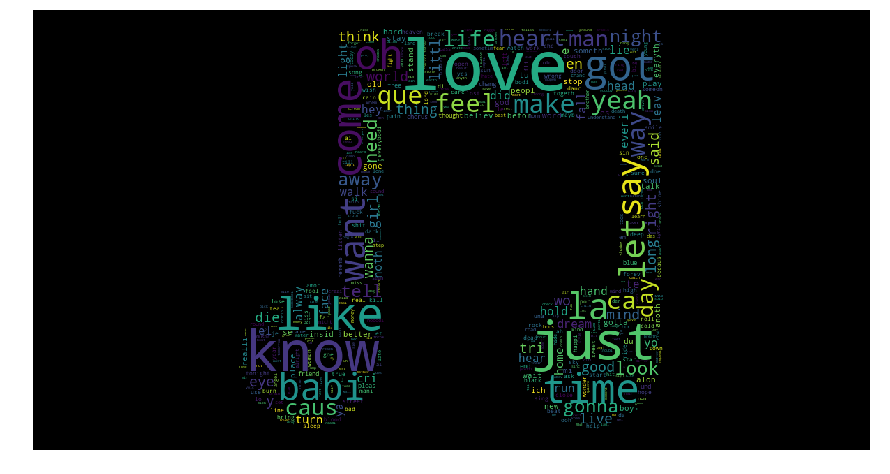

Year 1995


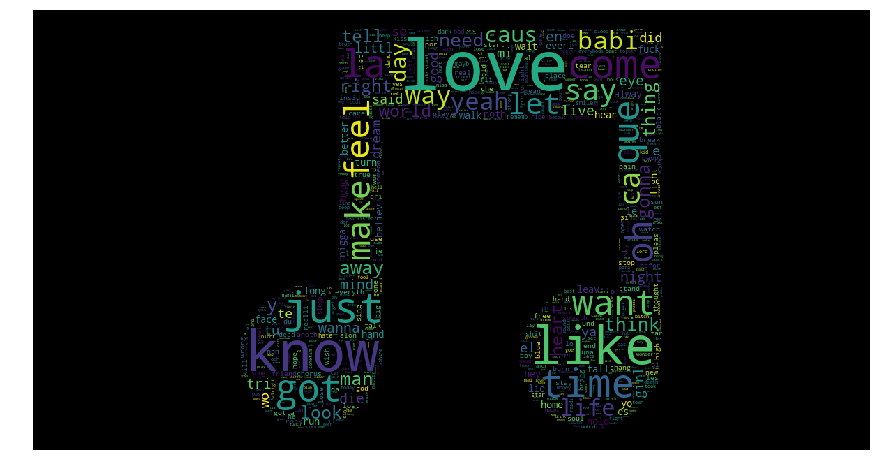

Year 2000


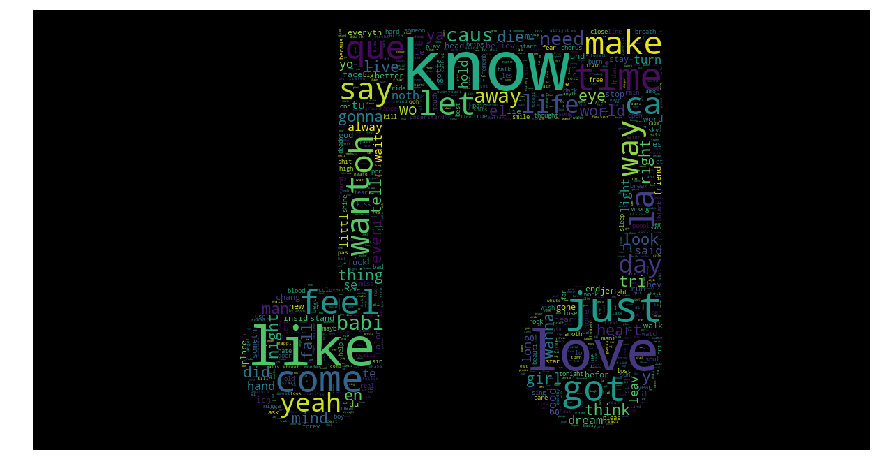

Year 2005


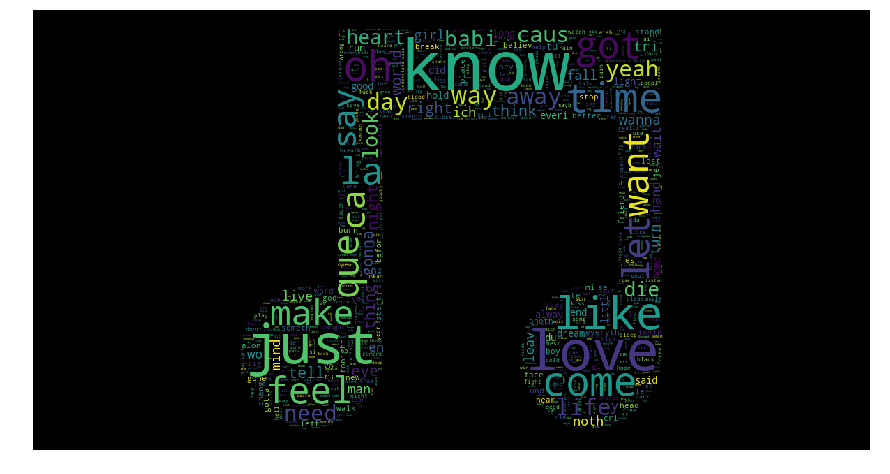

Year 2010


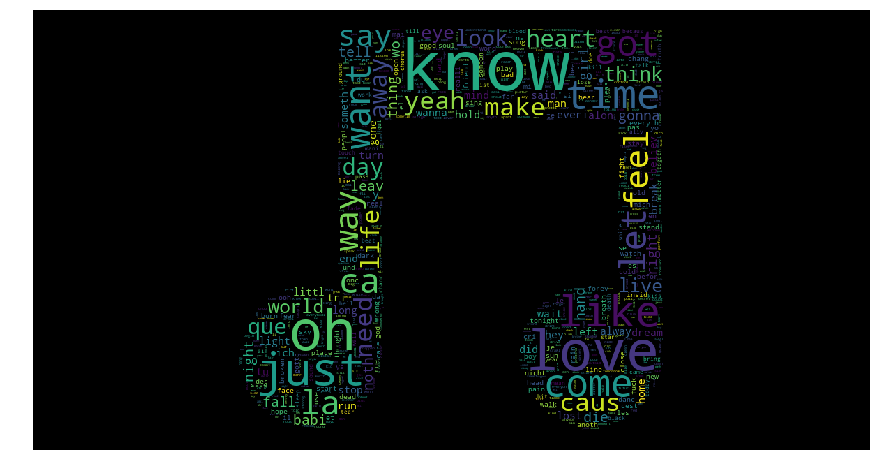

In [23]:
for year in orderedYearKeys:
    year_dict = yearWordsOcc[year]
    if len(year_dict) > 0:
        print("Year %d" % year)
        make_wordcloud(year_dict, mask=note_mask)